<a href="https://colab.research.google.com/github/ShawnLiu119/Online-Order-Prediction-Pricing-Discrimination/blob/main/order_pred_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn
!pip install xgboost
!pip install lightgbm

In [2]:
import sys
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as shc
import warnings
from collections import Counter
from functools import reduce
from itertools import chain
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, chi2, VarianceThreshold
#from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN, SMOTENC, SVMSMOTE, KMeansSMOTE, BorderlineSMOTE, ADASYN
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, SGDRegressor, Perceptron
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier, ExtraTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor, StackingClassifier, StackingRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, f1_score, silhouette_score
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/online_order_pred/

/content/drive/MyDrive/online_order_pred


In [6]:
import os
print(os.getcwd())  # Print the current working directory

/content/drive/MyDrive/online_order_pred


In [7]:
# import data
realclass_t1   = pd.read_csv('realclass_t1.txt', delimiter   = '|', na_values = ['?', '??'])
realClass_t2   = pd.read_csv('realClass_t2.txt', delimiter   = '|', na_values = ['?', '??'])
transact_class = pd.read_csv('transact_class.txt', delimiter = '|', na_values = ['?', '??'])
transact_train = pd.read_csv('transact_train.txt', delimiter = '|', na_values = ['?', '??'])

In [8]:
transact_train.loc[:, 'order'] = transact_train.loc[:, 'order'].map({'y': 1, 'n': 0})

transact_train.head()

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,...,NaN,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,1
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [9]:
transact_train['availability'].value_counts()

completely orderable           253692
mainly orderable                 5756
completely not orderable         1491
mixed                            1284
completely not determinable      1017
mainly not orderable              320
mainly not determinable           198
Name: availability, dtype: int64

In [10]:
transact_train.columns

Index(['sessionNo', 'startHour', 'startWeekday', 'duration', 'cCount',
       'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice',
       'bMaxPrice', 'bSumPrice', 'bStep', 'onlineStatus', 'availability',
       'customerNo', 'maxVal', 'customerScore', 'accountLifetime', 'payments',
       'age', 'address', 'lastOrder', 'order'],
      dtype='object')

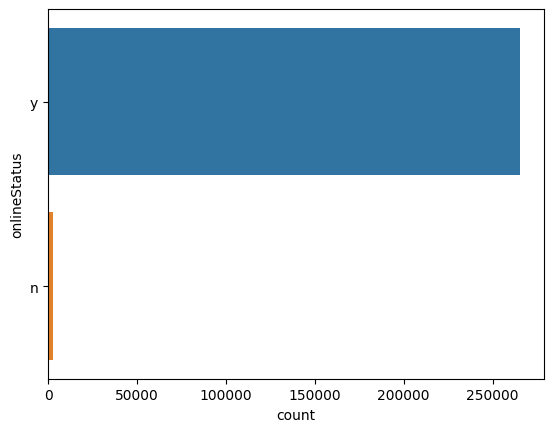

In [11]:
sns.countplot(data=transact_train, y="onlineStatus")
plt.show()

In [12]:
transact_train.drop(['customerNo'], axis = 1, inplace = True)
transact_train.drop(['availability'], axis = 1, inplace = True)
transact_train.drop(['sessionNo'], axis = 1, inplace = True)

In [13]:
transact_train.drop(['onlineStatus'], axis = 1, inplace = True)

### Feature Engineering

In [14]:
# Find the duplicates records in this dataset or not
if transact_train.duplicated().sum() > 0:
  print('There is duplicate values in this dataset. The number of duplicate value in this dataset is {}'.format(transact_train.duplicated().sum()))
else:
  print('No duplicate value in this dataset.')

There is duplicate values in this dataset. The number of duplicate value in this dataset is 4777


In [15]:
transact_train.drop_duplicates(inplace = True)
print("Duplicated value has been deleted.\n")

Duplicated value has been deleted.



In [16]:
transact_train.isnull().sum()

startHour               0
startWeekday            0
duration                0
cCount                  0
cMinPrice            1973
cMaxPrice            1973
cSumPrice            1973
bCount                  0
bMinPrice            4338
bMaxPrice            4338
bSumPrice            4338
bStep              186667
maxVal             149570
customerScore      149570
accountLifetime    149570
payments           146928
age                147226
address            146928
lastOrder          146928
order                   0
dtype: int64

In [17]:
# Mean Imputation for preventing the missing value
mean_imputation_column_ = [ 'cSumPrice', 'bMinPrice', 'bMaxPrice', 'bSumPrice']

def mean_imputation(column_):
  transact_train.loc[:, column_].fillna(transact_train.loc[:, column_].mean(), inplace = True)
  print(f'{column_} is Done.\n')

for column_ in mean_imputation_column_:
  mean_imputation(column_)

cSumPrice is Done.

bMinPrice is Done.

bMaxPrice is Done.

bSumPrice is Done.



In [18]:
# df_clean = transact_train.dropna()

# print('The shape of previous dataset is {}'.format(transact_train.shape),'\n')
# print('The shape of new dataset is {}'.format(df_clean.shape))

In [19]:
transact_train.columns

Index(['startHour', 'startWeekday', 'duration', 'cCount', 'cMinPrice',
       'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice',
       'bSumPrice', 'bStep', 'maxVal', 'customerScore', 'accountLifetime',
       'payments', 'age', 'address', 'lastOrder', 'order'],
      dtype='object')

In [20]:
capturing_NaN_list_ = list(transact_train.isnull().sum()[transact_train.isnull().sum()>0].index)
print('The list is {}'.format(capturing_NaN_list_),'\n\n')

The list is ['cMinPrice', 'cMaxPrice', 'bStep', 'maxVal', 'customerScore', 'accountLifetime', 'payments', 'age', 'address', 'lastOrder'] 




In [21]:
df = transact_train.copy()

In [22]:
capturing_NaN_list_ = list(transact_train.isnull().sum()[transact_train.isnull().sum()>0].index)
print('The list is {}'.format(capturing_NaN_list_),'\n\n')

for variable in capturing_NaN_list_:
    value_counts = df[variable].value_counts(normalize=True)
    # Generate random values based on the count distribution
    missing_indices = df[df[variable].isnull()].index
    num_missing_values = len(missing_indices)
    random_values = np.random.choice(value_counts.index, size=num_missing_values, p=value_counts.values)

    # Replace the missing values in the column with the generated values
    df.loc[missing_indices, variable] = random_values

The list is ['cMinPrice', 'cMaxPrice', 'bStep', 'maxVal', 'customerScore', 'accountLifetime', 'payments', 'age', 'address', 'lastOrder'] 




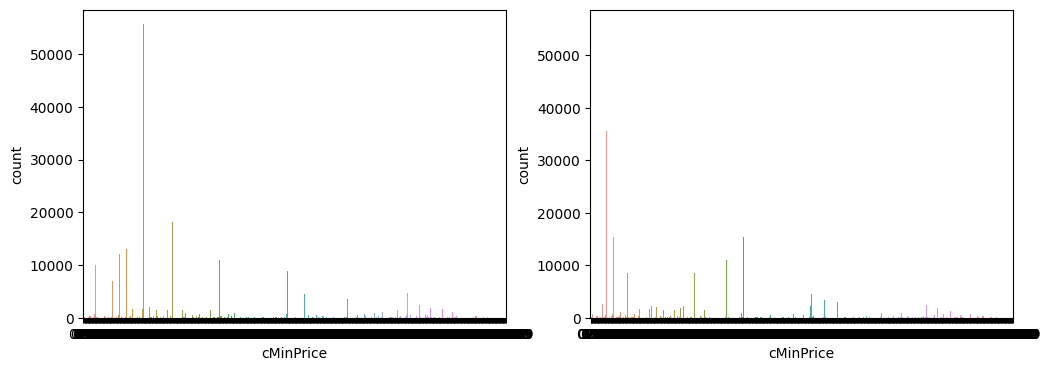

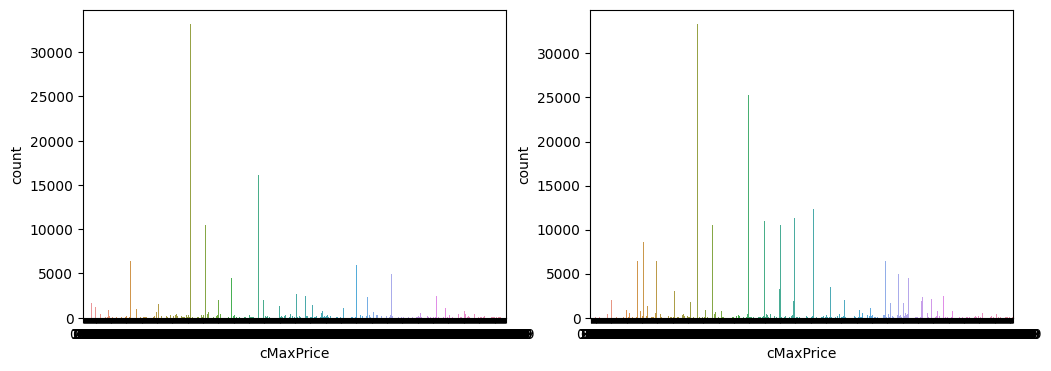

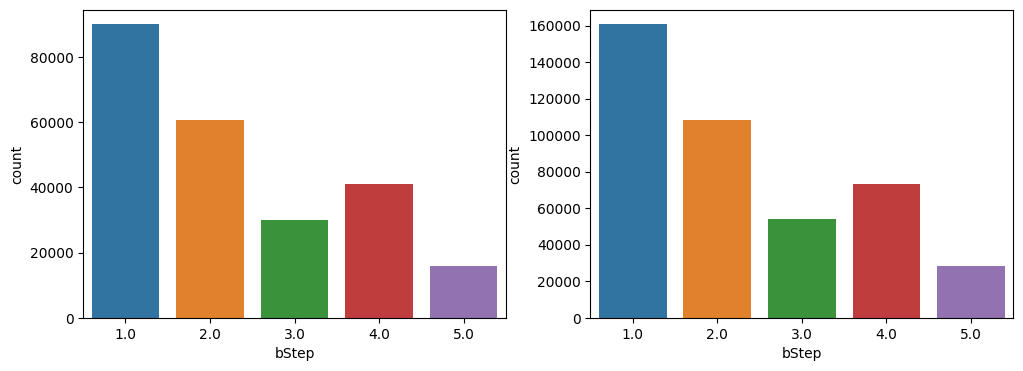

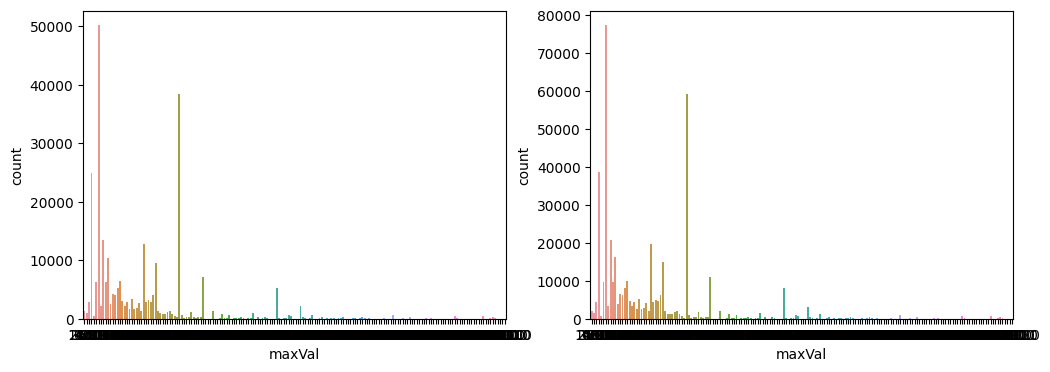

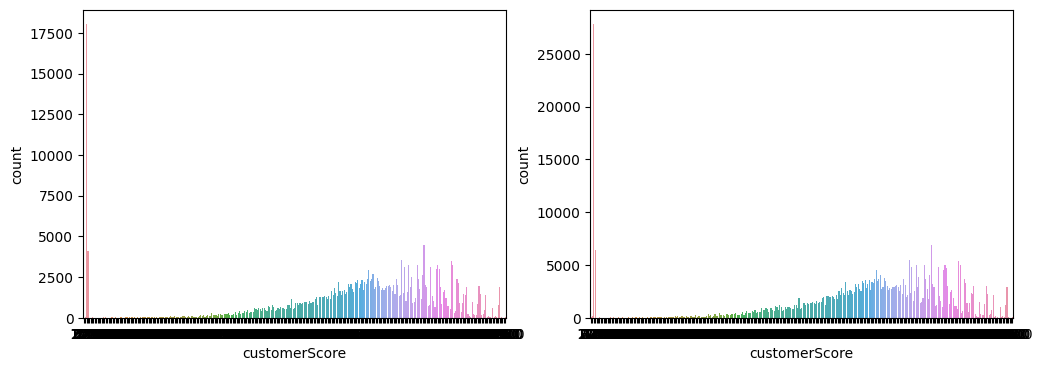

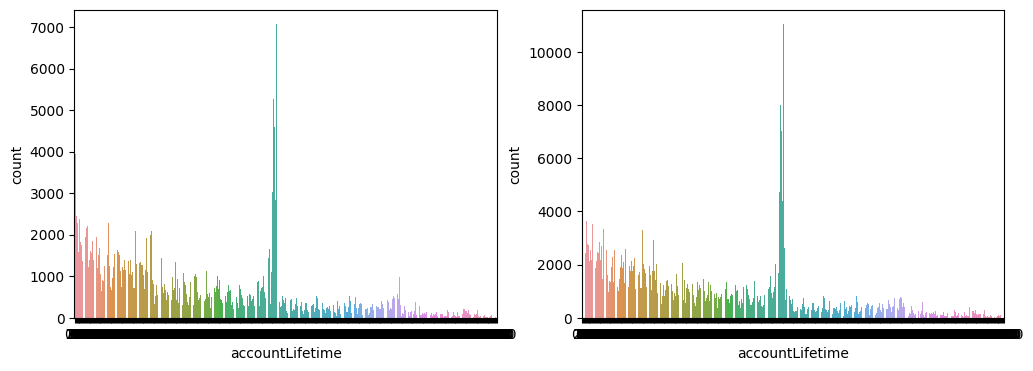

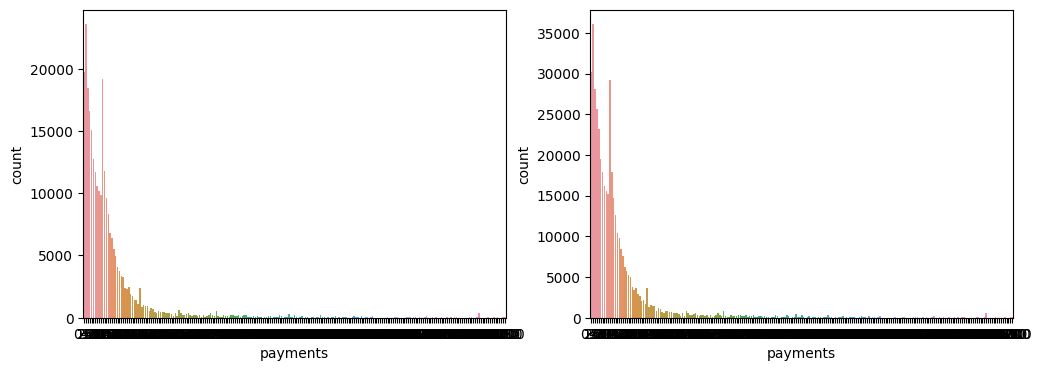

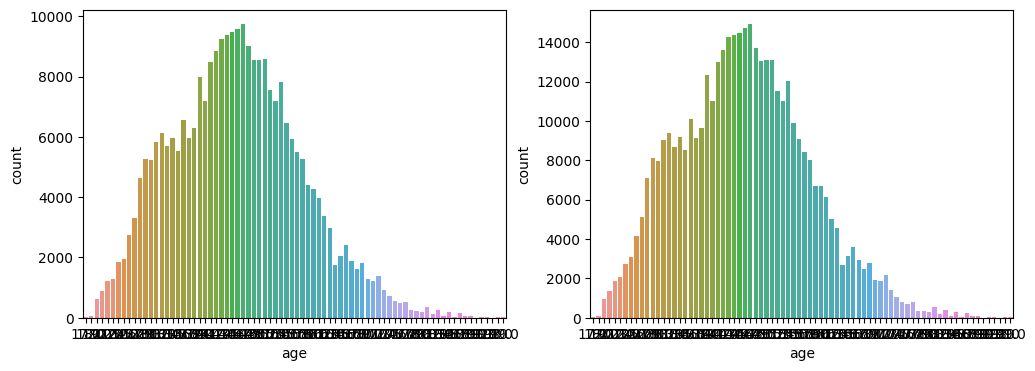

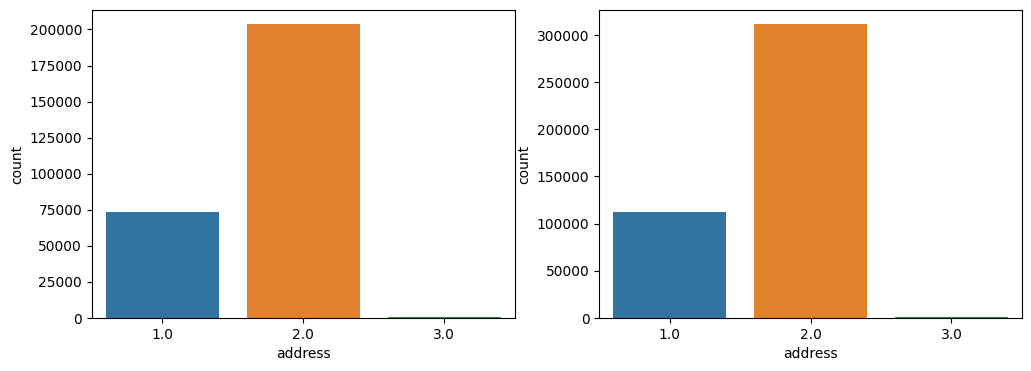

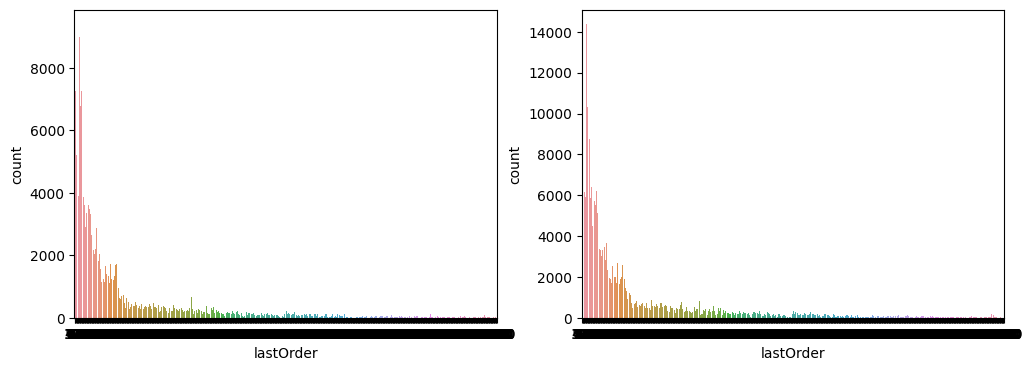

In [23]:
for variable in capturing_NaN_list_:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

    sns.countplot(data=transact_train, x=variable, ax=ax1)
    sns.countplot(data=df, x=variable, ax=ax2)

    # Show both subplots
    plt.show()

In [24]:
# Check NaN value removed or not
if df.isnull().sum().sum() == 0:
  print('NaN value is removed.')
else:
  print('NaN value in this dataset.')

NaN value is removed.


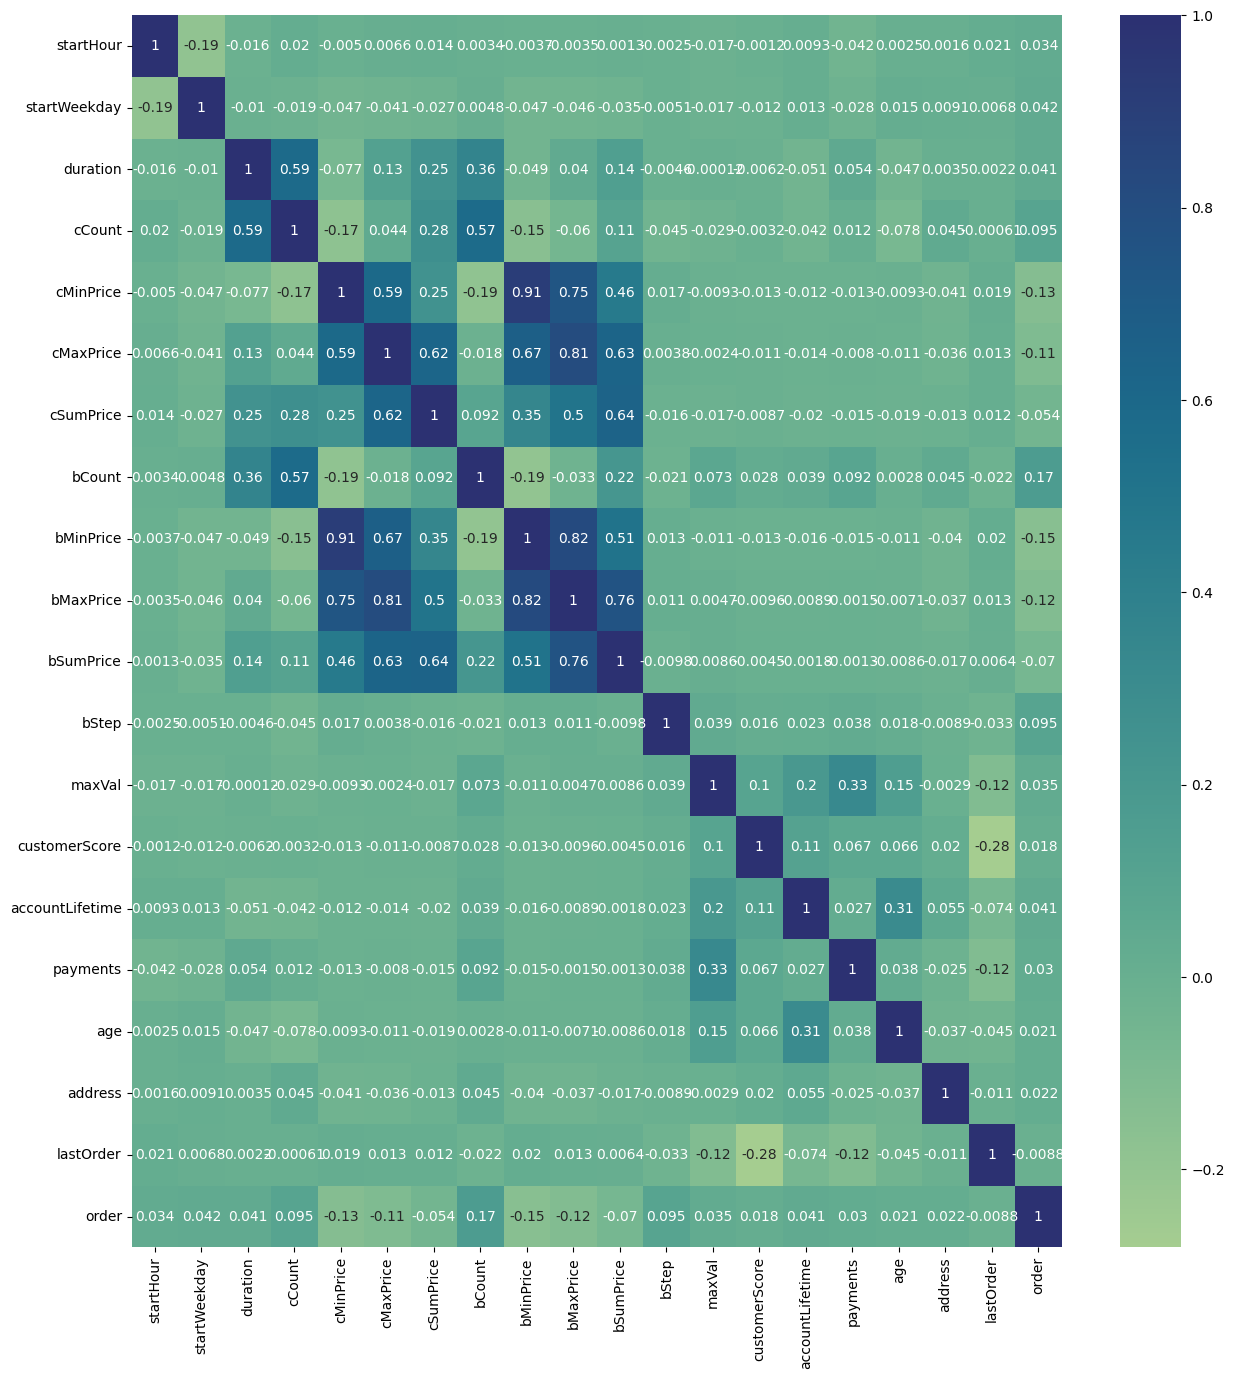

In [25]:
#explore colinearity
plt.figure(figsize = (15, 16))
sns.heatmap(df.corr(), cmap="crest", annot = True)
plt.show()

In [26]:
df.columns

Index(['startHour', 'startWeekday', 'duration', 'cCount', 'cMinPrice',
       'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice',
       'bSumPrice', 'bStep', 'maxVal', 'customerScore', 'accountLifetime',
       'payments', 'age', 'address', 'lastOrder', 'order'],
      dtype='object')

In [27]:
#deal with multicolinearity
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

num_col = ['startHour', 'startWeekday', 'duration', 'cCount',
       'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice',
       'bMaxPrice', 'bSumPrice', 'bStep', 'maxVal', 'customerScore', 'accountLifetime', 'payments',
       'age', 'lastOrder']

df_num = df[num_col]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]
vif_info['Column'] = df_num.columns
vif_info.sort_values('VIF', ascending=False)


,VIF,Column
1,23.808894,startWeekday
16,15.341391,age
13,14.029621,customerScore
9,10.303285,bMaxPrice
8,10.016960,bMinPrice
0,9.866839,startHour
4,7.201561,cMinPrice
5,4.847794,cMaxPrice
10,4.716684,bSumPrice
11,3.992924,bStep


In [28]:
df['cPriceDiff'] = df['cMaxPrice'] - df['cMinPrice']
df['bPriceDiff'] = df['bMaxPrice'] - df['bMinPrice']

df_clean = df.drop(['cMaxPrice', 'cMinPrice', 'bMaxPrice', 'bMinPrice', 'startWeekday'], axis=1, inplace=True)

In [29]:
# Drop the target column #####
y = df.loc[:, 'order']
df.drop(['order'], axis = 1, inplace = True)
print('The order column has been dropped.\n')
X = df.iloc[:]

print('The shape of X is {}'.format(X.shape))

The order column has been dropped.

The shape of X is (424236, 16)


In [30]:
df.columns

Index(['startHour', 'duration', 'cCount', 'cSumPrice', 'bCount', 'bSumPrice',
       'bStep', 'maxVal', 'customerScore', 'accountLifetime', 'payments',
       'age', 'address', 'lastOrder', 'cPriceDiff', 'bPriceDiff'],
      dtype='object')

In [31]:
# Handing the categorical data
df_dummies = pd.get_dummies(data = df, drop_first = True)
df_dummies.head()
df_dummies.shape

(424236, 16)

In [32]:
# Train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, shuffle = True, random_state = 42)

print('X_train shape is {}'.format(X_train.shape))
print('X_test  shape is {}'.format(X_test.shape))
print('y_train shape is {}'.format(y_train.shape))
print('y_test  shape is {}'.format(y_test.shape))

X_train shape is (296965, 16)
X_test  shape is (127271, 16)
y_train shape is (296965,)
y_test  shape is (127271,)


### Modeling

#### 11 models

In [ ]:
ml_models_ = {'NB': GaussianNB(), 'BNB': BernoulliNB(), 'SGD': SGDClassifier(), 'LR': LogisticRegression(),
              'Perceptron': Perceptron(), 'DT': DecisionTreeClassifier(),
              'RF': RandomForestClassifier(),'Adaboost': AdaBoostClassifier(), 'GB': GradientBoostingClassifier(), 'XGB': XGBClassifier(), 'LightGBM': LGBMClassifier()}

##### Run the model and check the perfprmance #####

performance_list_    = []

for key_, value_ in ml_models_.items():

  dataframe_dictonary_ = {}

  classifier_ = value_.fit(X_train, y_train)
  predicted_  = classifier_.predict(X_test)

  print('{} classifier is running:\n'.format(key_).upper())

  print("accuracy score  = ".title(), accuracy_score(predicted_, y_test))
  dataframe_dictonary_['accuracy score'.upper()] = accuracy_score(predicted_, y_test)

  print("Precision score = ".title(), precision_score(predicted_, y_test))
  dataframe_dictonary_['Precision score'.upper()] = precision_score(predicted_, y_test)

  print("recall score    = ".title(), recall_score(predicted_, y_test))
  dataframe_dictonary_['recall score'.upper()] = recall_score(predicted_, y_test)

  print("f1_score        = ".title(), f1_score(predicted_, y_test))
  dataframe_dictonary_['f1_score '.upper()] = f1_score(predicted_, y_test)

  print('*'*40,'\n')

  ##### Append this into performance list #####
  performance_list_.append(pd.DataFrame(dataframe_dictonary_, index = [key_.upper()]))

NB CLASSIFIER IS RUNNING:

Accuracy Score  =  0.6851546294550255
Precision Score =  0.9245137884319533
Recall Score    =  0.7062347070327917
F1_Score        =  0.8007656929770044
**************************************** 

BNB CLASSIFIER IS RUNNING:

Accuracy Score  =  0.6879989314224653
Precision Score =  0.9936051985029046
Recall Score    =  0.6885208079747329
F1_Score        =  0.8133966794956744
**************************************** 

SGD CLASSIFIER IS RUNNING:

Accuracy Score  =  0.6842746244264253
Precision Score =  0.9989208054924112
Recall Score    =  0.6845794944019135
F1_Score        =  0.8124034192503233
**************************************** 

LR CLASSIFIER IS RUNNING:

Accuracy Score  =  0.6890517945816833
Precision Score =  0.9719065004247893
Recall Score    =  0.6951298621318246
F1_Score        =  0.8105416856164874
**************************************** 

PERCEPTRON CLASSIFIER IS RUNNING:

Accuracy Score  =  0.6708388333647621
Precision Score =  0.9034580147413377

In [ ]:
# Show the performance of Ml algorithms in the DataFrame format
pd.concat(performance_list_)

,ACCURACY SCORE,PRECISION SCORE,RECALL SCORE,F1_SCORE
NB,0.685155,0.924514,0.706235,0.800766
BNB,0.687999,0.993605,0.688521,0.813397
SGD,0.684275,0.998921,0.684579,0.812403
LR,0.689052,0.971907,0.695130,0.810542
PERCEPTRON,0.670839,0.903458,0.701507,0.789777
DT,0.787298,0.848890,0.841672,0.845265
RF,0.861226,0.954892,0.858285,0.904015
ADABOOST,0.706448,0.921070,0.724639,0.811132
GB,0.719263,0.935501,0.730170,0.820179
XGB,0.770421,0.929715,0.778078,0.847164


Top 3 models are Random Forest, XGB, and LightGBM.

#### Stacking method

In [ ]:
# Using StackingClassifier to evaluate the model with CV = 10
estimators_ = [
    ('RF', RandomForestClassifier()),
    ('XGB', XGBClassifier()),
    ('LightGBM', LGBMClassifier())
]

##### Fit the model and find the performance #####

StackingClassifier_ = StackingClassifier(estimators = estimators_, final_estimator = RandomForestClassifier(), cv = 10)
StackingClassifier_.fit(X_train, y_train)

predicted_ = StackingClassifier_.predict(X_test)

print("accuracy score  = ".title(), accuracy_score(predicted_, y_test))
print("Precision score = ".title(), precision_score(predicted_, y_test))
print("recall score    = ".title(), recall_score(predicted_, y_test))
print("f1_score        = ".title(), f1_score(predicted_, y_test))

[LightGBM] [Info] Number of positive: 203110, number of negative: 93887
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3527
[LightGBM] [Info] Number of data points in the train set: 296997, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.683879 -> initscore=0.771656
[LightGBM] [Info] Start training from score 0.771656
[LightGBM] [Info] Number of positive: 182799, number of negative: 84498
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3527
[LightGBM] [Info] Number of data points in the train set: 267297, number of used features: 21
[LightGBM]

#### Ensemble using softvoting

In [ ]:
# Using StackingClassifier to evaluate the model with CV = 10
estimators_ = [
    ('RF', RandomForestClassifier()),
    ('XGB', XGBClassifier()),
    ('LightGBM', LGBMClassifier())
]

# Use ensemble voting method to find out the result
VotingClassifier_ = VotingClassifier(estimators = estimators_, voting = 'soft')
VotingClassifier_.fit(X_train, y_train)

predicted_ = VotingClassifier_.predict(X_test)

print("accuracy score  = ".title(), accuracy_score(predicted_, y_test))
dataframe_dictonary_['accuracy score'.upper()] = accuracy_score(predicted_, y_test)

print("Precision score = ".title(), precision_score(predicted_, y_test))
dataframe_dictonary_['Precision score'.upper()] = precision_score(predicted_, y_test)

print("recall score    = ".title(), recall_score(predicted_, y_test))
dataframe_dictonary_['recall score'.upper()] = recall_score(predicted_, y_test)

print("f1_score        = ".title(), f1_score(predicted_, y_test))
dataframe_dictonary_['f1_score '.upper()] = f1_score(predicted_, y_test)

[LightGBM] [Info] Number of positive: 202727, number of negative: 94238
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3179
[LightGBM] [Info] Number of data points in the train set: 296965, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.682663 -> initscore=0.766037
[LightGBM] [Info] Start training from score 0.766037
Accuracy Score  =  0.8121503551448865
Precision Score =  0.9561778145163142
Recall Score    =  0.8056512149822009
F1_Score        =  0.8744841924001722


#### Finetuning

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be a leaf node
}

In [ ]:
# rf_classifier = RandomForestClassifier(random_state=42)

# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='roc_auc', cv=3)

# # Perform the grid search on your data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and their corresponding accuracy score
# print('Best Parameters:', grid_search.best_params_)
# print('Best AUC Score:', grid_search.best_score_)
# print(gsearch.cv_results_['mean_test_score'])
# print(gsearch.cv_results_['params'])

The best hyper-parameters are:  
* Maximum tree depth: 8
* Minimum children samples: 18
* Minimum children weight: 0.001
* Number of leaves: 40

In [ ]:
# print('finished fine-tuning')

#### Using Best Model as Classifier for further analysis

In [33]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [34]:
print("accuracy score  = ".title(), accuracy_score(y_pred, y_test))
print("Precision score = ".title(), precision_score(y_pred, y_test))
print("recall score    = ".title(), recall_score(y_pred, y_test))
print("f1_score        = ".title(), f1_score(y_pred, y_test))

Accuracy Score  =  0.8448586087954051
Precision Score =  0.9494899600238937
Recall Score    =  0.8433925492076774
F1_Score        =  0.8933019912998837


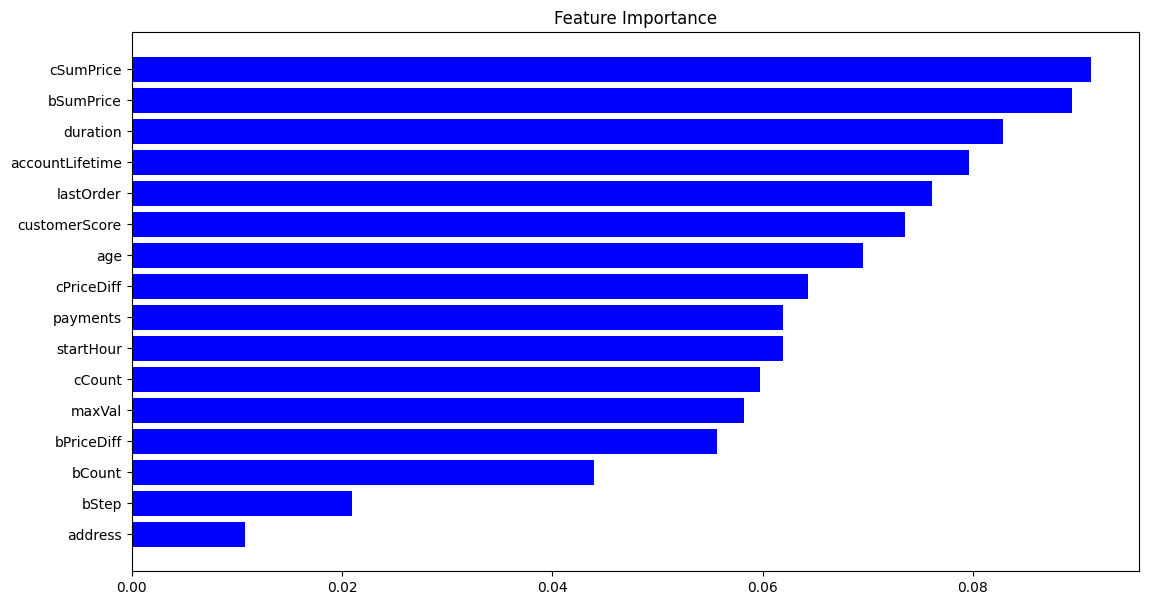

In [35]:
importances_values = model.feature_importances_
importances = pd.DataFrame(importances_values, columns=['importance'])
feature_data = pd.DataFrame(X_train.columns, columns=['feature'])
importance = pd.concat([feature_data, importances], axis=1)
importance = importance.sort_values(['importance'], ascending=True)
importance.set_index('feature', inplace=True)
importance = importance.reset_index()

plt.figure(figsize=(13, 7))
plt.barh(importance['feature'], importance['importance'], color='blue')
plt.title('Feature Importance')
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.62      0.72     40219
           1       0.84      0.95      0.89     87052

    accuracy                           0.84    127271
   macro avg       0.85      0.78      0.80    127271
weighted avg       0.85      0.84      0.84    127271



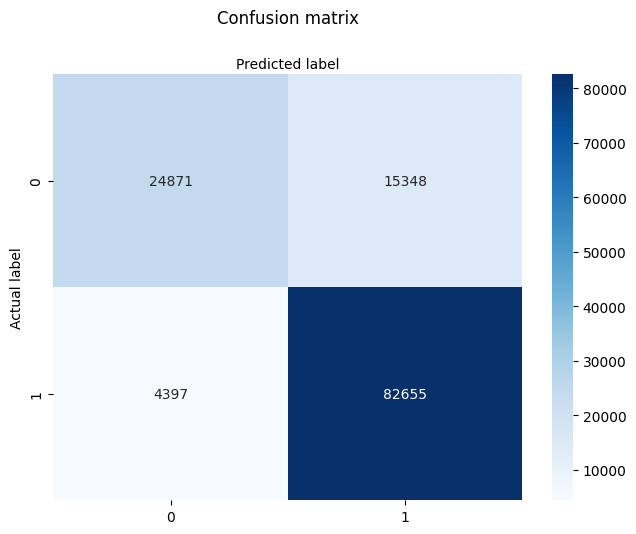

In [37]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

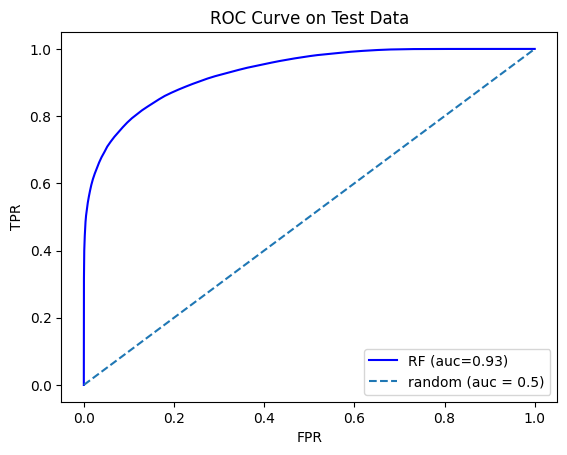

In [38]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = round(metrics.roc_auc_score(y_test, y_pred_proba),3)
plt.plot(fpr,tpr,label="RF (auc="+str(auc)+')', color='blue')
plt.plot([0, 1], [0, 1], label='random (auc = 0.5)', linestyle='--')
plt.title('ROC Curve on Test Data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.show()

In [ ]:
#plot the price
predicted_probabilities = model.predict_proba(X_test)
likelihood = predicted_probabilities[:, 1]
price = X_test['bSumPrice']

<Axes: xlabel='bSumPrice'>

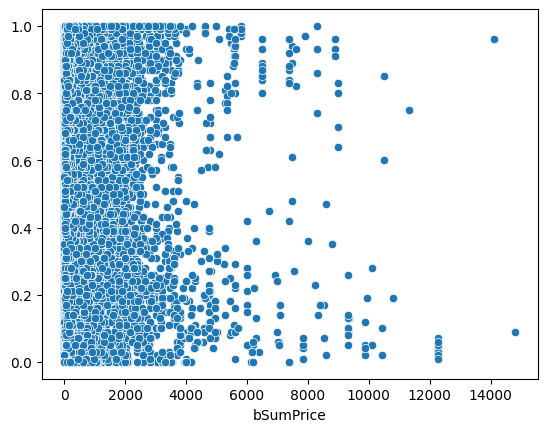

In [ ]:
sns.scatterplot(x=price, y=likelihood)

In [ ]:
x_group = X_test.copy()
x_group['prob'] = likelihood
x_group

,startHour,duration,cCount,cSumPrice,bCount,bSumPrice,bStep,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,cPriceDiff,bPriceDiff,prob
264813,19,223.729,3,19.98,1,9.99,3.0,4000.0,562.0,33.0,4.0,35.0,2.0,10.0,0.00,0.00,0.84
229157,16,947.800,22,500.72,13,282.85,1.0,25000.0,515.0,222.0,56.0,55.0,2.0,4.0,49.99,49.99,0.98
356131,12,7011.298,65,1156.51,3,59.93,2.0,600.0,541.0,44.0,2.0,36.0,2.0,222.0,81.00,20.04,0.95
266558,19,3275.340,17,9065.86,2,753.98,2.0,2500.0,549.0,134.0,22.0,60.0,2.0,38.0,845.01,746.00,0.33
409686,17,141.510,7,469.94,1,79.99,1.0,600.0,519.0,27.0,3.0,56.0,2.0,60.0,10.00,0.00,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341435,11,596.592,10,346.80,1,14.99,5.0,2700.0,519.0,64.0,6.0,42.0,2.0,64.0,182.48,0.00,0.68
35102,11,1307.429,28,501.74,7,114.94,1.0,800.0,470.0,143.0,5.0,40.0,2.0,22.0,81.99,32.99,0.82
403439,16,372.874,3,239.97,2,159.98,1.0,600.0,70.0,34.0,0.0,40.0,1.0,416.0,0.00,0.00,0.11
290155,21,2339.465,24,313.91,2,61.98,3.0,300.0,425.0,16.0,5.0,26.0,2.0,18.0,45.00,28.00,0.88


<Axes: title={'center': 'prob'}, xlabel='address'>

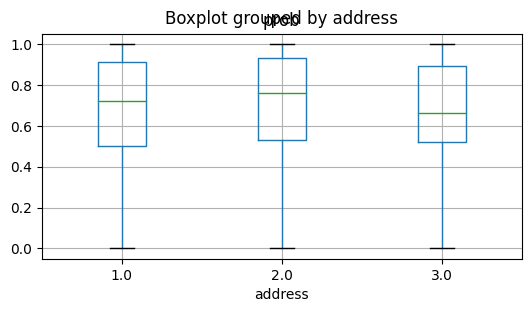

In [ ]:

fig, ax = plt.subplots(figsize=(6,3))
plt.suptitle('boxplot prob by address')
x_group.boxplot(column=['prob'], by='address', ax=ax)

<Axes: xlabel='cSumPrice'>

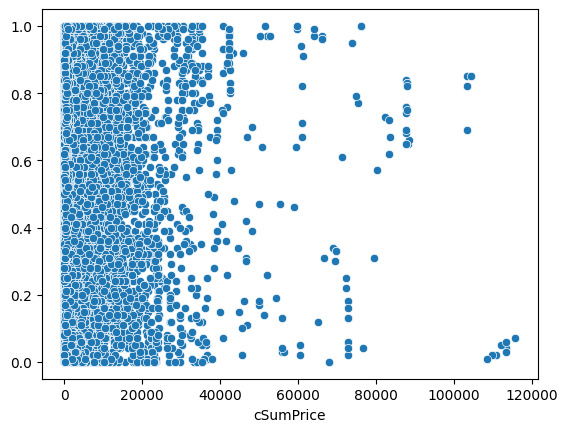

In [ ]:
sns.scatterplot(x=X_test['cSumPrice'], y=likelihood)

<Axes: xlabel='age'>

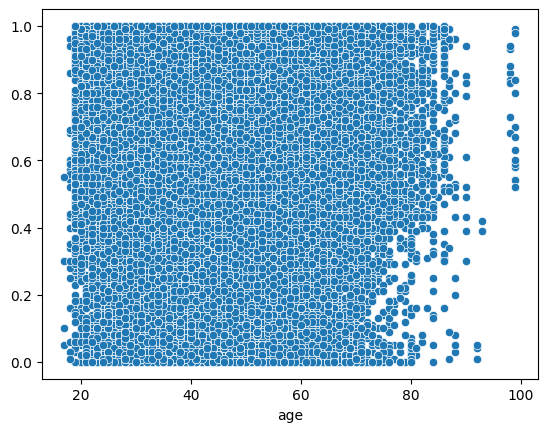

In [ ]:
sns.scatterplot(x=X_test['age'], y=likelihood)

In [41]:
def test_gen (df, column, delta):
  df_test = df.copy()
  df_test[column] = df_test[column] * (1 + delta)
  return df_test

In [54]:
df_p5 = test_gen(X, 'cSumPrice', 0.05)
df_p10 = test_gen(X, 'cSumPrice', 0.1)
df_p20 = test_gen(X, 'cSumPrice', 0.2)
df_p30 = test_gen(X, 'cSumPrice', 0.3)
df_p40 = test_gen(X, 'cSumPrice', 0.4)

df_n5 = test_gen(X, 'cSumPrice', -0.05)
df_n10 = test_gen(X, 'cSumPrice', -0.1)
df_n20 = test_gen(X, 'cSumPrice', -0.2)


In [39]:
pred_p5 = model.predict(df_p5)
pred_p10 = model.predict(df_p10)
pred_p20 = model.predict(df_p20)
pred_n5 = model.predict(df_n5)
pred_n10 = model.predict(df_n10)
pred_n20 = model.predict(df_n20)
pred_p30 = model.predict(df_p30)
pred_p40 = model.predict(df_p40)
pred_0 = model.predict(X_test)

In [40]:
delta = [-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2, 0.3, 0.4]
pred = [pred_n20, pred_n10, pred_n5, pred_0, pred_p5, pred_p10, pred_p20, pred_p30, pred_p40]

sales_dic = {}
for i in range(len(delta)):
  price = X_test['cSumPrice'] * (1+delta[i])
  sales_dic[delta[i]] = np.dot(price, pred[i])

sales_dic

{-0.2: 80007005.45901448,
 -0.1: 89453364.07578933,
 -0.05: 94343914.28508636,
 0: 98870873.83056417,
 0.05: 103719503.35434912,
 0.1: 108466869.15076786,
 0.2: 118156013.8671743,
 0.3: 127956051.50221607,
 0.4: 137562567.46347576}

In [41]:
order_dic = {}
for i in range(len(delta)):
  order_dic[delta[i]] = np.sum(pred[i])

order_dic

{-0.2: 98493,
 -0.1: 98184,
 -0.05: 98031,
 0: 97857,
 0.05: 97885,
 0.1: 97883,
 0.2: 97956,
 0.3: 97892,
 0.4: 97867}

In [42]:
df_rev_order = pd.DataFrame({'revenue':pd.Series(sales_dic),'order':pd.Series(order_dic)})

df_plot = df_rev_order.reset_index()
df_plot['index'] = df_plot['index'].astype('string')
df_plot

,index,revenue,order
0,-0.2,8.000701e+07,98493
1,-0.1,8.945336e+07,98184
2,-0.05,9.434391e+07,98031
3,0.0,9.887087e+07,97857
4,0.05,1.037195e+08,97885
5,0.1,1.084669e+08,97883
6,0.2,1.181560e+08,97956
7,0.3,1.279561e+08,97892
8,0.4,1.375626e+08,97867


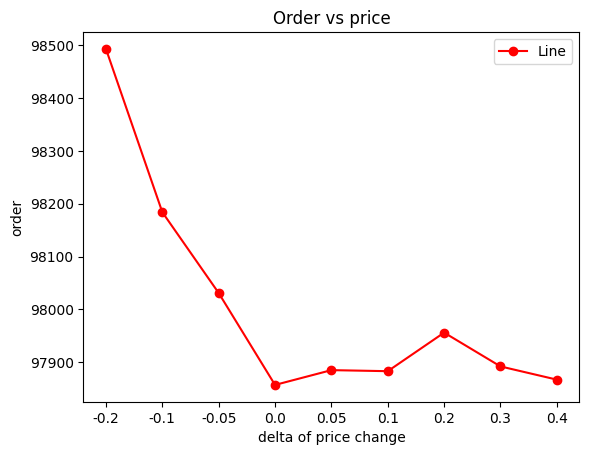

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots()



# df_plot.plot(kind='bar', x='index', y='revenue', ax=ax, color='b', alpha=0.5, label='Bar')
# plt.twinx()
# Plot a line chart
df_plot.plot(kind='line', x='index', y='order', ax=ax, color='r', marker='o', label='Line')

# Add a legend
ax.legend()

ax.set_xlabel('delta of price change')
ax.set_ylabel('order')
ax.set_title('Order vs price')

# Show the plot
plt.show()



In [58]:
#finde the most/least price sensitive population
pred_p20 = model.predict_proba(df_p20)[:, 1]
pred_0 = model.predict_proba(X)[:, 1]

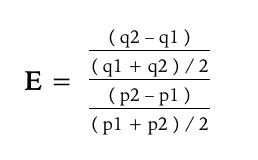

In [59]:
abs_elasticity = abs((pred_p20 - pred_0) / (pred_p20 + pred_0)/2 ) / (0.2 / (1 + 1.2))
abs_elasticity

array([0.63333333, 0.29289941, 0.14864865, ..., 0.1375    , 0.17741935,
       4.71428571])

In [60]:
price_elasticity_index = X.copy()
price_elasticity_index['elasticity'] = abs_elasticity
price_elasticity_index['likelihood'] = pred_0
price_elasticity_index

,startHour,duration,cCount,cSumPrice,bCount,bSumPrice,bStep,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,cPriceDiff,bPriceDiff,elasticity,likelihood
0,6,0.000,1,59.990000,1,59.990000,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,0.00,0.000000,0.633333,0.92
1,6,11.940,1,59.990000,1,59.990000,2.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,0.00,0.000000,0.292899,0.89
2,6,39.887,1,59.990000,1,59.990000,4.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,0.00,0.000000,0.148649,0.76
3,6,0.000,0,1199.272578,0,214.079176,2.0,300.0,486.0,35.0,11.0,31.0,2.0,14.0,33.99,40.102759,0.123596,0.91
4,6,15.633,0,1199.272578,0,214.079176,1.0,200.0,597.0,105.0,12.0,39.0,1.0,53.0,4.99,40.102759,0.030387,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429007,18,4700.383,50,2974.600000,2,159.980000,2.0,0.0,425.0,77.0,5.0,42.0,2.0,19.0,110.00,40.000000,0.523810,0.19
429008,18,5988.882,77,5253.280000,3,209.930000,4.0,300.0,539.0,73.0,11.0,32.0,2.0,21.0,140.00,50.040000,0.440000,0.23
429009,18,675.114,6,509.960000,1,89.990000,1.0,8100.0,534.0,117.0,0.0,24.0,1.0,4.0,140.99,0.000000,0.137500,0.41
429010,18,715.341,7,1159.950000,1,89.990000,1.0,4000.0,564.0,21.0,0.0,24.0,1.0,4.0,590.99,0.000000,0.177419,0.48


In [61]:
target_population = price_elasticity_index[price_elasticity_index['likelihood'] >= 0 ]
target_population['elasticity'].describe()

count    424049.000000
mean          0.485802
std           1.009390
min           0.000000
25%           0.057292
50%           0.141026
75%           0.354839
max           5.500000
Name: elasticity, dtype: float64

In [63]:
price_elasticity_index['elas_label'] = target_population['elasticity'].apply(lambda x: 'high' if x >= 1 else 'low')
price_elasticity_index['like_label'] = target_population['likelihood'].apply(lambda x: 'high' if x >= 0.5 else 'low')
price_elasticity_index


,startHour,duration,cCount,cSumPrice,bCount,bSumPrice,bStep,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,cPriceDiff,bPriceDiff,elasticity,likelihood,elas_label,like_label
0,6,0.000,1,59.990000,1,59.990000,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,0.00,0.000000,0.633333,0.92,low,high
1,6,11.940,1,59.990000,1,59.990000,2.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,0.00,0.000000,0.292899,0.89,low,high
2,6,39.887,1,59.990000,1,59.990000,4.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,0.00,0.000000,0.148649,0.76,low,high
3,6,0.000,0,1199.272578,0,214.079176,2.0,300.0,486.0,35.0,11.0,31.0,2.0,14.0,33.99,40.102759,0.123596,0.91,low,high
4,6,15.633,0,1199.272578,0,214.079176,1.0,200.0,597.0,105.0,12.0,39.0,1.0,53.0,4.99,40.102759,0.030387,0.91,low,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429007,18,4700.383,50,2974.600000,2,159.980000,2.0,0.0,425.0,77.0,5.0,42.0,2.0,19.0,110.00,40.000000,0.523810,0.19,low,low
429008,18,5988.882,77,5253.280000,3,209.930000,4.0,300.0,539.0,73.0,11.0,32.0,2.0,21.0,140.00,50.040000,0.440000,0.23,low,low
429009,18,675.114,6,509.960000,1,89.990000,1.0,8100.0,534.0,117.0,0.0,24.0,1.0,4.0,140.99,0.000000,0.137500,0.41,low,low
429010,18,715.341,7,1159.950000,1,89.990000,1.0,4000.0,564.0,21.0,0.0,24.0,1.0,4.0,590.99,0.000000,0.177419,0.48,low,low


In [64]:
price_elasticity_index.groupby(['elas_label', 'like_label'])['startHour'].count()


elas_label  like_label
high        high             100
            low            49549
low         high          301839
            low            72748
Name: startHour, dtype: int64

In [77]:
#for positive elas. increase price, for negative elas, decrease price

delta = 0.1
df_seg = price_elasticity_index.copy()
df_seg[df_seg['label'] == 'positive']['cSumPrice'] = df_seg[df_seg['label'] == 'positive']['cSumPrice'] * (1+delta)
df_seg[df_seg['label'] == 'positive']['bSumPrice'] = df_seg[df_seg['label'] == 'positive']['bSumPrice'] * (1+delta)

df_seg[df_seg['label'] == 'negative']['cSumPrice'] = df_seg[df_seg['label'] == 'negative']['cSumPrice'] * (1-delta)
df_seg[df_seg['label'] == 'negative']['bSumPrice'] = df_seg[df_seg['label'] == 'negative']['bSumPrice'] * (1-delta)

df_seg


,startHour,duration,cCount,cSumPrice,bCount,bSumPrice,bStep,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,cPriceDiff,bPriceDiff,elasticity,label
264813,19,223.729,3,19.98,1,9.99,3.0,2500.0,571.0,152.0,4.0,70.0,2.0,115.0,0.00,0.00,0.166667,positive
229157,16,947.800,22,500.72,13,282.85,1.0,25000.0,515.0,222.0,56.0,55.0,2.0,4.0,49.99,49.99,-0.084615,negative
356131,12,7011.298,65,1156.51,3,59.93,2.0,600.0,541.0,44.0,2.0,36.0,2.0,222.0,81.00,20.04,-0.086387,negative
266558,19,3275.340,17,9065.86,2,753.98,2.0,2500.0,549.0,134.0,22.0,60.0,2.0,38.0,845.01,746.00,-0.314286,negative
409686,17,141.510,7,469.94,1,79.99,4.0,800.0,496.0,51.0,3.0,34.0,2.0,5.0,10.00,0.00,-0.695402,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341435,11,596.592,10,346.80,1,14.99,5.0,600.0,502.0,48.0,10.0,49.0,1.0,52.0,182.48,0.00,-0.134146,negative
35102,11,1307.429,28,501.74,7,114.94,5.0,800.0,470.0,143.0,5.0,40.0,2.0,22.0,81.99,32.99,-0.029730,negative
403439,16,372.874,3,239.97,2,159.98,1.0,600.0,70.0,34.0,0.0,40.0,1.0,416.0,0.00,0.00,1.241935,positive
290155,21,2339.465,24,313.91,2,61.98,4.0,300.0,425.0,16.0,5.0,26.0,2.0,18.0,45.00,28.00,0.000000,negative


In [80]:
df_seg[df_seg['label'] == 'positive']['cSumPrice'] = df_seg[df_seg['label'] == 'positive']['cSumPrice'] * 1.1
df_seg

,startHour,duration,cCount,cSumPrice,bCount,bSumPrice,bStep,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,cPriceDiff,bPriceDiff,elasticity,label
264813,19,223.729,3,19.98,1,9.99,3.0,2500.0,571.0,152.0,4.0,70.0,2.0,115.0,0.00,0.00,0.166667,positive
229157,16,947.800,22,500.72,13,282.85,1.0,25000.0,515.0,222.0,56.0,55.0,2.0,4.0,49.99,49.99,-0.084615,negative
356131,12,7011.298,65,1156.51,3,59.93,2.0,600.0,541.0,44.0,2.0,36.0,2.0,222.0,81.00,20.04,-0.086387,negative
266558,19,3275.340,17,9065.86,2,753.98,2.0,2500.0,549.0,134.0,22.0,60.0,2.0,38.0,845.01,746.00,-0.314286,negative
409686,17,141.510,7,469.94,1,79.99,4.0,800.0,496.0,51.0,3.0,34.0,2.0,5.0,10.00,0.00,-0.695402,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341435,11,596.592,10,346.80,1,14.99,5.0,600.0,502.0,48.0,10.0,49.0,1.0,52.0,182.48,0.00,-0.134146,negative
35102,11,1307.429,28,501.74,7,114.94,5.0,800.0,470.0,143.0,5.0,40.0,2.0,22.0,81.99,32.99,-0.029730,negative
403439,16,372.874,3,239.97,2,159.98,1.0,600.0,70.0,34.0,0.0,40.0,1.0,416.0,0.00,0.00,1.241935,positive
290155,21,2339.465,24,313.91,2,61.98,4.0,300.0,425.0,16.0,5.0,26.0,2.0,18.0,45.00,28.00,0.000000,negative


#### Random shift 20% population


In [ ]:
from random import sample

price_index = df.sample(frac=0.2, random_state=1).index

In [ ]:
sample_list = price_index.tolist()

In [ ]:
X_test.index

Int64Index([264813, 229157, 356131, 266558, 409686, 102976, 105577,  86949,
            226163, 172653,
            ...
             65226, 130100, 196831, 316626, 233627, 341435,  35102, 403439,
            290155, 147405],
           dtype='int64', length=127271)

In [ ]:
def price_cus(df, delta):
  x_p = df.copy()
  for i in sample_list:
    x_p.iloc[i]['bSumPrice'] = x_p.iloc[i]['bSumPrice'] * (1+delta)
    x_p.iloc[i]['cSumPrice'] = x_p.iloc[i]['cSumPrice'] * (1+delta)
  return x_p


In [ ]:
for i in sample_list:
  print (X_test.loc[i])

KeyError: ignored

In [ ]:
df_p5 = price_cus(X_test, 0.05)
df_p10 = price_cus(X_test,  0.1)
df_p20 = price_cus(X_test,  0.2)
df_p30 = price_cus(X_test,  0.3)
df_p40 = price_cus(X_test,  0.4)

df_n5 = price_cus(X_test,  -0.05)
df_n10 = price_cus(X_test,  -0.1)
df_n20 = price_cus(X_test,  -0.2)

IndexError: ignored

In [ ]:
pred_p5 = model.predict(df_p5)
pred_p10 = model.predict(df_p10)
pred_p20 = model.predict(df_p20)
pred_n5 = model.predict(df_n5)
pred_n10 = model.predict(df_n10)
pred_n20 = model.predict(df_n20)
pred_p30 = model.predict(df_p30)
pred_p40 = model.predict(df_p40)
pred_0 = model.predict(X_test)

In [ ]:
delta = [-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2, 0.3, 0.4]
pred = [pred_n20, pred_n10, pred_n5, pred_0, pred_p5, pred_p10, pred_p20, pred_p30, pred_p40]

sales_dic = {}
for i in range(len(delta)):
  price = X_test['cSumPrice'] * (1+delta[i])
  sales_dic[delta[i]] = np.dot(price, pred[i])

sales_dic

{-0.2: 79978664.55913967,
 -0.1: 89492097.69339135,
 -0.05: 94211948.41612336,
 0: 98913468.44665936,
 0.05: 103962071.9355776,
 0.1: 108633070.0139807,
 0.2: 118325074.59742726,
 0.3: 127975001.2763051,
 0.4: 137784748.4357137}

In [ ]:
order_dic = {}
for i in range(len(delta)):
  order_dic[delta[i]] = np.sum(pred[i])

order_dic

{-0.2: 98528,
 -0.1: 98278,
 -0.05: 98089,
 0: 97935,
 0.05: 98000,
 0.1: 98032,
 0.2: 98210,
 0.3: 98020,
 0.4: 98120}

In [ ]:
df_rev_order = pd.DataFrame({'revenue':pd.Series(sales_dic),'order':pd.Series(order_dic)})

df_plot = df_rev_order.reset_index()
df_plot['index'] = df_plot['index'].astype('string')
df_plot

,index,revenue,order
0,-0.2,7.997866e+07,98528
1,-0.1,8.949210e+07,98278
2,-0.05,9.421195e+07,98089
3,0.0,9.891347e+07,97935
4,0.05,1.039621e+08,98000
5,0.1,1.086331e+08,98032
6,0.2,1.183251e+08,98210
7,0.3,1.279750e+08,98020
8,0.4,1.377847e+08,98120


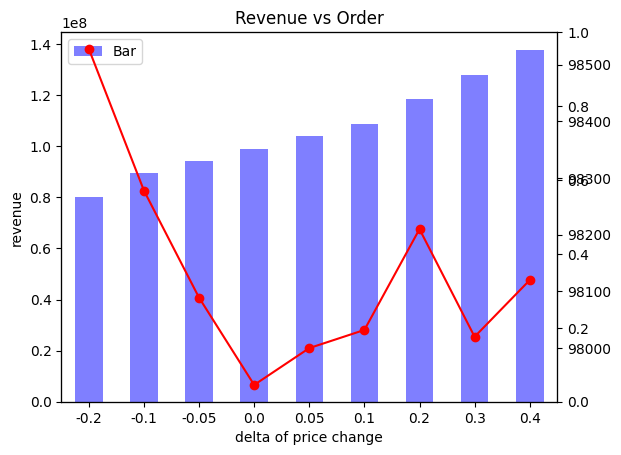

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots()



df_plot.plot(kind='bar', x='index', y='revenue', ax=ax, color='b', alpha=0.5, label='Bar')
plt.twinx()
# Plot a line chart
df_plot.plot(kind='line', x='index', y='order', ax=ax, color='r', marker='o', label='Line', secondary_y = True)

# Add a legend
ax.legend()

ax.set_xlabel('delta of price change')
ax.set_ylabel('revenue')
ax.set_title('Revenue vs Order')

# Show the plot
plt.show()



### change threshold

In [ ]:
def test_gen (df, column, delta):
  df_test = df.copy()
  df_test[column] = df_test[column] * (1 + delta)
  return df_test

In [ ]:
df_p5 = test_gen(X_test, 'cSumPrice', 0.05)
df_p10 = test_gen(X_test, 'cSumPrice', 0.1)
df_p20 = test_gen(X_test, 'cSumPrice', 0.2)
df_p30 = test_gen(X_test, 'cSumPrice', 0.3)
df_p40 = test_gen(X_test, 'cSumPrice', 0.4)

df_n5 = test_gen(X_test, 'cSumPrice', -0.05)
df_n10 = test_gen(X_test, 'cSumPrice', -0.1)
df_n20 = test_gen(X_test, 'cSumPrice', -0.2)


In [ ]:
delta = [-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2]
pred = [pred_n20, pred_n10, pred_n5, pred_0, pred_p5, pred_p10, pred_p20]

sales_dic = {}
for i in range(len(delta)):
  price = X_test['bSumPrice'] * (1+delta[i])
  sales_dic[delta[i]] = np.dot(price, pred[i])

sales_dic

{-0.2: 12471741.250759875,
 -0.1: 14012247.210914627,
 -0.05: 14818181.523668602,
 0: 15647635.144387519,
 0.05: 16320512.481162298,
 0.1: 17013425.914982393,
 0.2: 18404520.44912848}

In [ ]:
order_dic = {}
for i in range(len(delta)):
  order_dic[delta[i]] = np.sum(pred[i])

order_dic

{-0.2: 86086,
 -0.1: 86188,
 -0.05: 86156,
 0: 86342,
 0.05: 86164,
 0.1: 85963,
 0.2: 85581}

In [ ]:
df_rev_order = pd.DataFrame({'revenue':pd.Series(sales_dic),'order':pd.Series(order_dic)})

df_plot = df_rev_order.reset_index()
df_plot['index'] = df_plot['index'].astype('string')
df_plot

,index,revenue,order
0,-0.2,7.032913e+07,86086
1,-0.1,7.906946e+07,86188
2,-0.05,8.355038e+07,86156
3,0.0,8.825962e+07,86342
4,0.05,9.210250e+07,86164
5,0.1,9.604447e+07,85963
6,0.2,1.040485e+08,85581


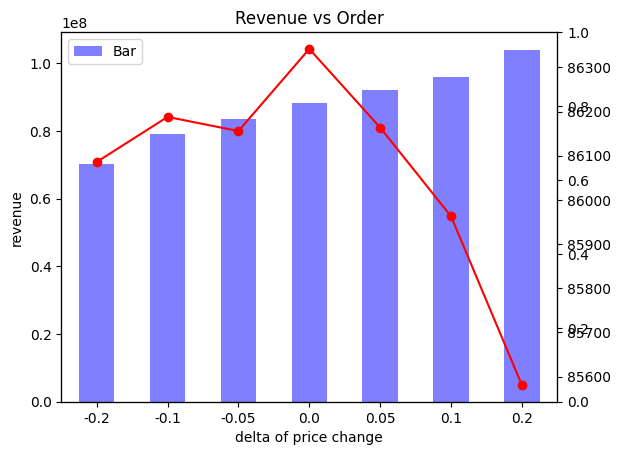

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots()

df_plot.plot(kind='bar', x='index', y='revenue', ax=ax, color='b', alpha=0.5, label='Bar')
plt.twinx()
# Plot a line chart
df_plot.plot(kind='line', x='index', y='order', ax=ax, color='r', marker='o', label='Line', secondary_y = True)

# Add a legend
ax.legend()

ax.set_xlabel('delta of price change')
ax.set_ylabel('revenue')
ax.set_title('Revenue vs Order')

# Show the plot
plt.show()